# Introduction

This notebook will take a data-driven approach to generating word lists for mental functions that are related to brain circuitry. The overall process is as follows:

1. Group brain structures into circuits based on co-occurrences with mental functioning terms.
2. Identify the mental functioning terms most closely related to each circuit across list lengths.
3. Select the list lengths that maximize variance explained in relation to brain circuitry.
4. Select the number of circuits that maximizes circuit-function classification performance.

# Load the data

In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(42)
from listify import *

## Brain activations mapped to Harvard-Oxford structures

In [2]:
atlas_labels = pd.read_csv("../data/atlases/harvard-oxford.csv")
act_bin = pd.read_csv("../data/dcm_0mm_thres0.csv", index_col=0) # Previously binarized
act_bin = act_bin[atlas_labels["PREPROCESSED"]]

## Document-term matrix (DTM) for cognitive neuroscience lexicon

In [3]:
rdoc_version = 190124

In [4]:
dtm = pd.read_csv("../data/dtm_{}.csv.gz".format(rdoc_version), compression="gzip", index_col=0)

In [5]:
lexicon = [tkn.strip() for tkn in open("../data/lexicon/lexicon_cogneuro_preproc.txt", "r") if tkn.strip() in list(dtm.columns)]
rdoc_seeds = [seed for seed in set(pd.read_csv("../data/rdoc_{}/rdoc_seeds.csv".format(rdoc_version))["TOKEN"]) if seed in dtm.index]
lexicon = sorted(list(set(lexicon + rdoc_seeds)))
dtm = dtm[lexicon]
len(lexicon)

2208

In [6]:
dtm_bin = np.empty((dtm.shape[0], dtm.shape[1]))
for i, (word, mean_docfreq) in enumerate(dtm.mean().iteritems()):
    dtm_bin[:,i] = 1 * (dtm[word] > mean_docfreq)
dtm_bin = pd.DataFrame(dtm_bin, index=dtm.index, columns=dtm.columns)

## Training and validation sets

In [7]:
train = [int(pmid.strip()) for pmid in open("../data/splits/train.txt")]
val = [int(pmid.strip()) for pmid in open("../data/splits/validation.txt")]
test = [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]

In [8]:
len(train)

12708

In [9]:
len(val)

3631

In [10]:
len(test)

1816

## Classifier fits

In [11]:
import pickle

In [12]:
circuit_counts = range(2,41)

In [13]:
fits = {}
directions = ["forward", "reverse"]
for d in directions:
    fits[d] = {}
    for k in circuit_counts:
        fits[d][k] = pickle.load(open("classifiers/fits/{}_k{:02d}_oplen.p".format(d, k), "rb"))

/Users/ehbeam/anaconda/envs/rdoc/lib/python2.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ehbeam/anaconda/envs/rdoc/lib/python2.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ehbeam/anaconda/envs/rdoc/lib/python2.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator OneVsRestClassifier from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Model brain systems

## Structure-term co-occurrence matrix

In [14]:
def observed_over_expected(df):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    oe = df / expected
    return oe

def pmi(df, positive=True):
    df = observed_over_expected(df)
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
    return df

In [15]:
stm = np.matmul(act_bin.loc[train].transpose(), dtm_bin.loc[train])
stm = pd.DataFrame(stm, columns=dtm.columns, index=act_bin.columns)
stm = pmi(stm, positive=False)
stm = stm.dropna(axis=1, how="any")
stm = stm.loc[:, (stm != 0).any(axis=0)]
stm.head()

,3d_object,abductive_reasoning,abstract_analogy,abstract_concrete_task,abstract_knowledge,abstract_pattern,abstract_task,abstractconcrete_task,acoustic_encoding,acoustic_phonetic_processing,...,working_memory_retrieval,working_memory_storage,working_memory_updating,write,writing,writing_task,young_mania_rating_scale,zimbardo_time_perspective_inventory,zoo_map_test,zuckerman_sensation_seeking_scale
left_frontal_pole,-0.526979,0.019405,0.613461,1.182556,-0.051279,-0.124013,0.164310,0.307087,0.0,0.113318,...,0.196811,0.051154,0.148270,0.054337,0.020388,-0.332572,0.230394,0.846083,-0.112171,0.640231
left_insular_cortex,-0.449645,0.348054,-0.156503,0.000000,-0.415778,-0.097645,-0.075025,0.635736,0.0,-0.104577,...,0.129564,0.115110,-0.216228,0.011422,-0.041963,-0.147024,0.062606,0.000000,0.216477,0.458054
left_superior_frontal_gyrus,0.034631,0.070189,0.664245,0.827875,0.060130,-0.212991,0.181193,0.357871,0.0,-0.072287,...,0.208374,-0.048344,0.150264,0.070030,0.025674,0.342367,-0.215258,0.896868,-0.061387,0.180190
left_middle_frontal_gyrus,0.135680,-0.038482,0.150109,0.719204,0.062684,-0.021557,0.316144,0.000000,0.0,0.246486,...,0.230731,0.082214,0.159376,0.072316,0.051938,0.233696,0.032746,0.788197,-0.170058,0.071519
left_inferior_frontal_gyrus_pars_triangularis,-0.012570,0.267185,0.455776,0.000000,0.062969,0.166327,0.188947,0.000000,0.0,0.189248,...,0.156908,-0.028279,-0.045783,0.112875,0.051521,-0.394947,0.072709,1.093863,0.135608,-0.028279


In [16]:
stm.loc["left_amygdala"].sort_values(ascending=False)[:10]

olfactory_stimulus_transduction      4.273268
auditory_system_function             3.174656
letter_naming_task                   2.886974
eye_puff                             2.481509
face_identification_task             2.427441
waisinformation                      2.039676
emotion_expression_identification    2.039676
pavlovian_conditioning_task          2.021976
social_norm_processing_task          1.970683
offensive_aggression                 1.937893
Name: left_amygdala, dtype: float64

## K-means clustering of structures by activations

In [17]:
from sklearn.cluster import KMeans
from scipy.stats import pointbiserialr
import warnings
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [18]:
circuit_counts = range(2, 58) # Max k set to 114 structures / 2
list_lens = range(5, 26) # Same range as RDoC

In [19]:
for k in circuit_counts:
    
    # Generate circuit by k-means clustering
    circuit_file = "../lists/circuits/circuits_k{:02d}.csv".format(k)
    if not os.path.isfile(circuit_file):
        kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42)
        kmeans.fit(stm)
        clust = pd.DataFrame({"STRUCTURE": act_bin.columns, 
                              "CLUSTER": [l+1 for l in list(kmeans.labels_)]})
        clust = clust.sort_values(["CLUSTER", "STRUCTURE"])
        clust.to_csv(circuit_file, index=None)
    else:
        clust = pd.read_csv(circuit_file, index_col=None)
    
    # Identify words for mental functions most correlated with each circuit
    outfile = "lists/lists_k{:02d}.csv".format(k)
    if not os.path.isfile(outfile):
        lists = pd.DataFrame()
        for i in range(k):
            structures = list(clust.loc[clust["CLUSTER"] == i+1, "STRUCTURE"])
            centroid = np.mean(act_bin.loc[train, structures], axis=1)
            R = pd.Series([pointbiserialr(dtm_bin.loc[train, word], centroid)[0] 
                           for word in dtm.columns], index=dtm.columns)
            R = R[R > 0].sort_values(ascending=False)[:max(list_lens)]
            R = pd.DataFrame({"CLUSTER": [i+1 for l in range(max(list_lens))], 
                              "TOKEN": R.index, "R": R.values})
            lists = lists.append(R)
        lists.to_csv(outfile, index=None)

In [ ]:
for k in circuit_counts:
    
    # Generate circuit by k-means clustering
    circuit_file = "../lists/circuits/circuits_k{:02d}.csv".format(k)
    if not os.path.isfile(circuit_file):
        kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42)
        kmeans.fit(stm)
        clust = pd.DataFrame({"STRUCTURE": act_bin.columns, 
                              "CLUSTER": [l+1 for l in list(kmeans.labels_)]})
        clust = clust.sort_values(["CLUSTER", "STRUCTURE"])
        clust.to_csv(circuit_file, index=None)
    else:
        clust = pd.read_csv(circuit_file, index_col=None)
    
    # Identify words for mental functions most correlated with each circuit
    outfile = "lists/lists_k{:02d}.csv".format(k)
    if not os.path.isfile(outfile):
        lists = pd.DataFrame()
        for i in range(k):
            structures = list(clust.loc[clust["CLUSTER"] == i+1, "STRUCTURE"])
            
            centroid = np.mean(act_bin.loc[train, structures], axis=1)
            R = pd.Series([pointbiserialr(dtm_bin.loc[train, word], centroid)[0] 
                           for word in dtm.columns], index=dtm.columns)
            R = R[R > 0].sort_values(ascending=False)[:max(list_lens)]
            R = pd.DataFrame({"CLUSTER": [i+1 for l in range(max(list_lens))], 
                              "TOKEN": R.index, "R": R.values})
            lists = lists.append(R)
#         lists.to_csv(outfile, index=None)

# Build the framework

## Select the optimal number of words per domain

Word list lengths were selected by mean ROC-AUC of forward and reverse classifiers for each circuit. The number of circuits will be selected across values of k using the lists of optimized length, this time training classifiers that use all the circuits at that k. All classifiers were optimized over a grid search for regularization strength, penalty, and intercept.

## Select the optimal number of domains

### Figure setup

In [16]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

In [177]:
arial = "../style/Arial Unicode.ttf"
font_prop = font_manager.FontProperties(fname=arial, size=20)
font_prop_lg = font_manager.FontProperties(fname=arial, size=22)
rcParams["axes.linewidth"] = 1.5

In [546]:
circuit_counts = range(2, 41)
directions = ["forward", "reverse"]
shapes = [">", "<", "D"]

In [161]:
op_idx = [np.argmax(rocauc_scores["mean"][:5]),
          np.argmax(rocauc_scores["mean"][5:10])+5, 
          np.argmax(rocauc_scores["mean"][10:20])+10]

In [551]:
def plot_scores(scores, boot, null, label, ylabel="", ylim=[0,1]):
    
    for i, direction in enumerate(directions + ["mean"]):

        fig = plt.figure(figsize=(4, 3))
        ax = fig.add_axes([0,0,1,1])
        
        # Plot null distribution
        n_iter = float(null[direction].shape[1])
        null_lower = [sorted(null[direction][k,:])[int(n_iter*0.001)] for k in range(len(circuit_counts))]
        null_upper = [sorted(null[direction][k,:])[int(n_iter*0.999)] for k in range(len(circuit_counts))]
        plt.fill_between(circuit_counts, null_lower, null_upper, 
                         alpha=0.2, color="gray")
        plt.plot(circuit_counts, np.mean(null[direction], axis=1), 
                 linestyle="dashed", c="k", alpha=1, linewidth=2)
        
        n_iter = float(boot[direction].shape[1])
        boot_lower = [sorted(boot[direction][k,:])[int(0.001*n_iter)] for k in range(len(circuit_counts))]
        boot_upper = [sorted(boot[direction][k,:])[int(0.999*n_iter)] for k in range(len(circuit_counts))]
        for j, k in enumerate(circuit_counts):
            plt.plot([k, k], [boot_lower[j], boot_upper[j]], c="k", 
                     linewidth=9, alpha=0.15)

        plt.scatter(circuit_counts, scores[direction], color="black", 
                    marker=shapes[i], zorder=1000, s=45, alpha=0.3)
        
        xp = np.linspace(circuit_counts[0], circuit_counts[-1], 100)
        idx = np.isfinite(scores[direction])
        p = np.poly1d(np.polyfit(np.array(circuit_counts)[idx], scores[direction][idx], 2))
        plt.plot(xp, p(xp), zorder=0, linewidth=2, 
                 color="black", alpha=1)

        plt.scatter(circuit_counts[op_idx[1]]+0.03, scores[direction][op_idx[1]]-0.00015, 
                    linewidth=2.5, edgecolor="black", color="none", 
                    marker=shapes[i], s=70, zorder=100)

        plt.xlim([0,41])
        plt.ylim(ylim)
        plt.xticks(fontproperties=font_prop)
        plt.yticks(fontproperties=font_prop)
        ax.xaxis.set_tick_params(width=1.5, length=7)
        ax.yaxis.set_tick_params(width=1.5, length=7)
        for side in ["right", "top"]:
            ax.spines[side].set_visible(False)
        plt.ylabel(ylabel, fontproperties=font_prop_lg)
        ax.yaxis.set_label_coords(-0.16,0.5)

        plt.savefig("figures/kmeans_{}_{}.png".format(label, direction), 
                    dpi=250, bbox_inches="tight")
        plt.show()

### Circuit features

In [137]:
from sklearn.preprocessing import binarize

In [139]:
def mean_thres(df):
    col_mean = df.mean()
    df_bin = np.empty((df.shape[0], df.shape[1]))
    i = 0
    for col, doc_mean in col_mean.iteritems():
        df_bin[:,i] = 1 * (df[col] > doc_mean)
        i += 1
    df_bin = pd.DataFrame(df_bin, columns=df.columns, index=df.index)
    return df_bin

In [318]:
features = {}
for k in circuit_counts:
    
    list_file = "lists/lists_k{:02d}_oplen.csv".format(k)
    lists = pd.read_csv(list_file, index_col=None)
    
    circuit_file = "circuits/circuits_k{:02d}.csv".format(k)
    circuits = pd.read_csv(circuit_file, index_col=None)
    
    function_features = pd.DataFrame(index=dtm_bin.index, columns=range(1, k+1))
    structure_features = pd.DataFrame(index=act_bin.index, columns=range(1, k+1))
    for i in range(1, k+1):
        functions = lists.loc[lists["CLUSTER"] == i, "TOKEN"]
        function_features[i] = dtm_bin[functions].sum(axis=1)
        structures = circuits.loc[circuits["CLUSTER"] == i, "STRUCTURE"]
        structure_features[i] = act_bin[structures].sum(axis=1)
    function_features = mean_thres(function_features)
    function_features = pd.DataFrame(binarize(function_features), 
                                     index=dtm_bin.index, columns=range(1, k+1))
    structure_features = pd.DataFrame(binarize(structure_features), 
                                     index=act_bin.index, columns=range(1, k+1))
    
    features[k] = {}
    features[k]["function"] = function_features
    features[k]["structure"] = structure_features

### Functions for evaluating the validation set

In [522]:
def compute_eval_scores(scoring_function):
    eval_scores = {direction: np.zeros((len(circuit_counts))) for direction in directions}
    for i, k in enumerate(circuit_counts):

        y_pred_for = fits["forward"][k].predict(features[k]["function"].loc[val])
        y_true_for = features[k]["structure"].loc[val]
        y_pred_rev = fits["reverse"][k].predict(features[k]["structure"].loc[val])
        y_true_rev = features[k]["function"].loc[val]

        score_for = scoring_function(y_true_for.values, y_pred_for, average=None)
        eval_scores["forward"][i] = np.mean(score_for)
        score_rev = scoring_function(y_true_rev.values, y_pred_rev, average=None)
        eval_scores["reverse"][i] = np.mean(score_rev)

    eval_scores["mean"] = np.mean([eval_scores["forward"], eval_scores["reverse"]], axis=0)
    return eval_scores

In [422]:
def compute_eval_boot(scoring_function, n_iter=1000):
    eval_boot = {direction: np.zeros((len(circuit_counts), n_iter)) for direction in directions}
    for i, k in enumerate(circuit_counts):

        if i % 10 == 0:
            print("Processing {}th k".format(i))

        y_pred_for = fits["forward"][k].predict(features[k]["function"].loc[val])
        y_true_for = features[k]["structure"].loc[val]
        y_pred_rev = fits["reverse"][k].predict(features[k]["structure"].loc[val])
        y_true_rev = features[k]["function"].loc[val]

        for n in range(n_iter):
            boot = np.random.choice(range(len(val)), size=len(val), replace=True)
            score_for = scoring_function(y_true_for.values[boot,:], y_pred_for[boot,:], average=None)
            eval_boot["forward"][i,n] = np.mean(score_for)
            score_rev = scoring_function(y_true_rev.values[boot,:], y_pred_rev[boot,:], average=None)
            eval_boot["reverse"][i,n] = np.mean(score_rev)

    eval_boot["mean"] = np.mean([eval_boot["forward"], eval_boot["reverse"]], axis=0)
    return eval_boot

In [535]:
def compute_eval_null(scoring_function, n_iter=1000):
    eval_null = {direction: np.zeros((len(circuit_counts), n_iter)) for direction in directions}
    for i, k in enumerate(circuit_counts):

        if i % 10 == 0:
            print("Processing {}th k".format(i))

        y_pred_for = fits["forward"][k].predict(features[k]["function"].loc[val])
        y_true_for = features[k]["structure"].loc[val]
        y_pred_rev = fits["reverse"][k].predict(features[k]["structure"].loc[val])
        y_true_rev = features[k]["function"].loc[val]

        for n in range(n_iter):
            null = np.random.choice(range(len(val)), size=len(val), replace=False)
            score_for = scoring_function(y_true_for.values[null,:], y_pred_for, average=None)
            eval_null["forward"][i,n] = np.mean(score_for)
            score_rev = scoring_function(y_true_rev.values[null,:], y_pred_rev, average=None)
            eval_null["reverse"][i,n] = np.mean(score_rev)

    eval_null["mean"] = np.mean([eval_null["forward"], eval_null["reverse"]], axis=0)
    return eval_null

### Area under the receiver operating characteristic curve (ROC-AUC)

Previously computed on Sherlock in the validation set.

In [516]:
from sklearn.metrics import roc_auc_score

In [524]:
rocauc_scores = compute_eval_scores(roc_auc_score)

In [530]:
rocauc_boot = compute_eval_boot(roc_auc_score, n_iter=10000)

Processing 0th k
Processing 10th k
Processing 20th k
Processing 30th k


In [554]:
rocauc_null = compute_eval_null(roc_auc_score, n_iter=10000)

Processing 0th k
Processing 10th k
Processing 20th k
Processing 30th k


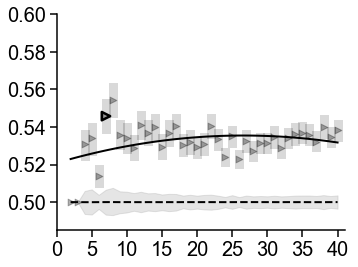

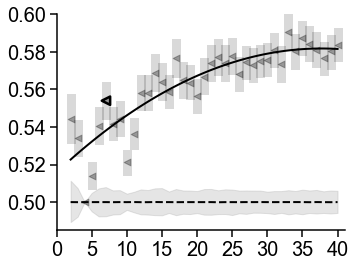

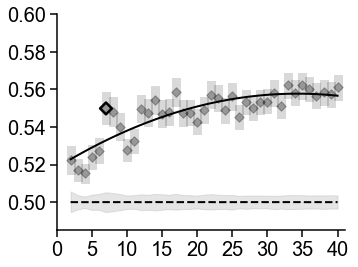

In [558]:
plot_scores(rocauc_scores, rocauc_boot, rocauc_null, "rocauc", ylim=[0.485,0.6])

### Bayesian information criterion (BIC)

In [508]:
def bic_score(y_true, y_pred, average=None):
    k = float(y_true.shape[1])
    n = float(y_true.shape[0])
    resid = y_true - y_pred
    sse = np.sum(resid ** 2, axis=0)
    return (k * np.log(n)) - (2 * np.log(sse))

In [509]:
bic_scores = compute_eval_scores(bic_score)

In [511]:
bic_boot = compute_eval_boot(bic_score, n_iter=1000)

Processing 0th k
Processing 10th k
Processing 20th k
Processing 30th k


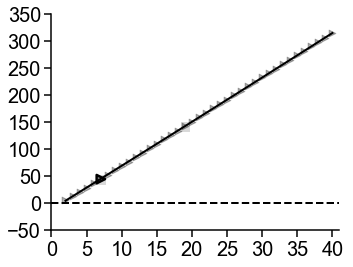

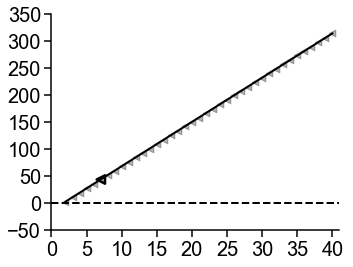

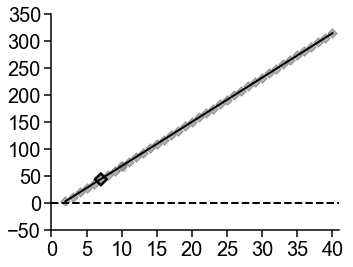

In [515]:
plot_scores(bic_scores, bic_boot, "bic", ylim=[-50,350])

# Link systems into an hierarchy

Based on cosine similarity of circuit-function links.

In [20]:
from scipy.spatial.distance import cosine
from collections import OrderedDict

In [18]:
levels = ["Domains", "Constructs", "Subconstructs"]
op_k = [circuit_counts[op_idx[i]] for i in range(len(op_idx))]
for i in range(len(op_idx)):
    print("{} at k={}".format(levels[i], op_k[i]))

Domains at k=2
Constructs at k=7
Subconstructs at k=17


In [19]:
links = []
for k in op_k:
    
    circuit_file = "circuits/circuits_k{:02d}.csv".format(k)
    circuits = pd.read_csv(circuit_file, index_col=None)
    
    list_file = "lists/lists_k{:02d}_oplen.csv".format(k)
    lists = pd.read_csv(list_file, index_col=None)
    
    links_k = pd.DataFrame(columns=range(k))
    for i in range(k):
        stm = pd.DataFrame(0, index=act_bin.columns, columns=dtm.columns)
        structures = circuits.loc[circuits["CLUSTER"] == i+1, "STRUCTURE"]
        tokens = lists.loc[lists["CLUSTER"] == i+1, "TOKEN"]
        stm.loc[structures, tokens] = 1
        links_k[i] = stm.values.ravel()
    links.append(links_k)

In [20]:
dist_l1 = pd.DataFrame(0, index=range(op_k[0]), columns=range(op_k[1]))
for j in range(op_k[0]):
    for k in range(op_k[1]):
        dist_l1.loc[j, k] = cosine(links[0][j], links[1][k])

dist_l2 = pd.DataFrame(0, index=range(op_k[0]), columns=range(op_k[1]))
for j in range(op_k[1]):
    for k in range(op_k[2]):
        dist_l2.loc[j, k] = cosine(links[1][j], links[2][k])

In [21]:
# Initialize the hierarchy with domains
hier = {dom: [] for dom in range(1, op_k[0]+1)}

# Load constructs into the domains
for con in range(op_k[1]):
    dists = dist_l1[con].sort_values()
    dom = dists.index[0]
    hier[dom+1].append(con+1)

# Link constructs to superseding domains
con2dom = {}
for dom, cons in hier.items():
    for con in cons:
        con2dom[con] = dom
    
# Order constructs within domains    
for dom in range(op_k[0]):
    ordered_cons = list(dist_l1.loc[dom, hier[dom+1]].sort_values().index)
    hier[dom+1] = OrderedDict([(con, []) for con in ordered_cons])

# Load subconstructs into the constructs    
for sub in range(op_k[2]):
    dists = dist_l2[sub].sort_values()
    con = dists.index[0]
    for dom, cons in hier.items():
        if con+1 in cons:
            hier[dom][con+1].append(sub+1)
            
# Order subconstructs within constructs         
for con in range(op_k[1]):
    dom = con2dom[con+1]
    ordered_subs = list(dist_l2.loc[con, hier[dom][con+1]].sort_values().index)
    hier[dom][con+1] = ordered_subs

hier

/Users/ehbeam/anaconda/envs/rdoc/lib/python2.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


{1: OrderedDict([(6, [8, 9]), (3, [6, 12, 15])]),
 2: OrderedDict([(1, [3, 11]),
              (4, [5, 7, 16]),
              (2, [1, 10]),
              (5, [4, 14, 17]),
              (7, [13, 2])])}

# Name the systems

In [22]:
import word_forms
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [23]:
def load_systems(k):
    list_file = "lists/lists_k{:02d}_oplen.csv".format(k)
    lists = pd.read_csv(list_file, index_col=None)
    circuit_file = "circuits/circuits_k{:02d}.csv".format(k)
    circuits = pd.read_csv(circuit_file, index_col=None)
    return lists, circuits

In [24]:
def nounify(word):
    words = wordnet.synsets(word)
    if len(words) > 0:
        if words[0].pos() != "n":
            nouns = list(word_forms.get_word_forms(word)["n"])
            if len(nouns) > 0:
                return str(nouns[0])
            else:
                return word
        else:
            return word
    else:
        return word

In [556]:
def token_degree_centrality(i, lists, circuits, reweight=False):
    tokens = list(set(lists.loc[lists["CLUSTER"] == i, "TOKEN"]))
    ttm = pd.DataFrame(np.matmul(dtm_bin.loc[train, tokens].T, dtm_bin.loc[train, tokens]), 
                       index=tokens, columns=tokens)
    nodes = list(tokens) + list(structures)
    adj = pd.DataFrame(0, index=nodes, columns=nodes)
    for tkn_i in tokens:
        for tkn_j in tokens:
            adj.loc[tkn_i, tkn_j] = ttm.loc[tkn_i, tkn_j]
    degrees = adj.sum(axis=1)
    degrees = degrees.loc[tokens]
    degrees = degrees.sort_values(ascending=False)
    return degrees

In [26]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [27]:
id2name, hier_names = {}, {}

## Super-domains

In [28]:
level = 0
lists, circuits = load_systems(2)
for dom, cons in hier.items():
    degrees = token_degree_centrality(dom, lists, circuits)
    name = nounify(degrees.index[0])
    hier_names[name] = hier[dom]
    id = "{}_{}".format(level, dom)
    id2name[id] = name
    print(name)

arousal
manipulation


## Domains

In [29]:
level = 1
lists, circuits = load_systems(op_k[level])
for sup, doms in hier_names.items():
    dom_names = []
    for dom, cons in doms.items():
        degrees = token_degree_centrality(dom, lists, circuits)
        name = nounify(degrees.index[0])
        dom_names.append((name, cons))
        id = "{}_{}".format(level, dom)
        id2name[id] = name
        print(name)
    hier_names[sup] = dom_names

emotion
anticipation
meaning
language
manipulation
vision
cognition


## Constructs

In [30]:
level = 2
lists, circuits = load_systems(op_k[level])
lists["TOKEN"] = [nounify(tkn) for tkn in list(lists["TOKEN"])]

In [31]:
con_degrees = pd.DataFrame(0, index=list(set(lists["TOKEN"])), columns=range(op_k[2]))
con_names = {}
for sup, doms in hier_names.items():
    for dom, cons in doms:
        for con in cons:
            degrees = token_degree_centrality(con, lists, circuits)
            con_names[con] = list(degrees.index[:3])
            for name, degree in degrees.iteritems():
                con_degrees.loc[name, con-1] = degree
con_degrees[con_degrees.isna()] = 0 

In [32]:
while len(set(flatten(con_names.values()))) < len(flatten(con_names.values())):
    for con, names in con_names.items():
        for name in names:
            if flatten(con_names.values()).count(name) > 1:
                other_cons = [other_con for other_con, con_name in con_names.items() if name in con_name]
                degrees = [con_degrees.loc[name, other_con-1] for other_con in other_cons]
                winner = other_cons[degrees.index(max(degrees))]
                losers = [other_con for other_con in other_cons if other_con != winner]
                for loser in losers:
                    con_degrees.loc[name, loser-1] = 0
                    tkns = []
                    new_name = list(con_degrees[loser-1].sort_values(ascending=False).index[:3])
                    con_names[loser] = new_name
                    print("Reassigned {} from {}, yielding: {}".format(name, loser, ", ".join(new_name)))         
print("")

Reassigned preparation from 1, yielding: execution, hand, representation
Reassigned manipulation from 2, yielding: cognition, cognitive_process, reaction_time
Reassigned manipulation from 4, yielding: vision, attention, reaction_time
Reassigned cognitive_process from 10, yielding: manipulation, preparation, reaction_time
Reassigned word from 3, yielding: retrieval, memory, episodic_memory
Reassigned word from 16, yielding: language, speech, language_processing
Reassigned retrieval from 3, yielding: memory, episodic_memory, familiarity
Reassigned memory from 3, yielding: episodic_memory, familiarity, recognition
Reassigned memory from 11, yielding: episodic_memory, retrieval, recall
Reassigned memory from 14, yielding: episodic_memory, recall, retrieval
Reassigned vision from 17, yielding: representation, perception, word
Reassigned perception from 5, yielding: language, speech, hearing
Reassigned language from 5, yielding: speech, hearing, listening
Reassigned language from 16, yieldin

In [33]:
for sup, doms in hier_names.items():
    ordered_doms = []
    for dom, cons in doms:
        ordered_cons = []
        for con in cons:
            ordered_cons.append(con_names[con])
        ordered_doms.append((dom, ordered_cons))
    hier_names[sup] = ordered_doms
hier_names

{'arousal': [('emotion',
   [['emotion', 'arousal', 'fear'], ['memory', 'recall', 'episodic_memory']]),
  ('anticipation',
   [['reward_processing', 'reward_anticipation', 'reward_learning'],
    ['salience', 'mood', 'decision_making'],
    ['reward', 'anticipation', 'feedback']])],
 'manipulation': [('meaning',
   [['semantic_processing', 'recognition_memory', 'naming'],
    ['retrieval', 'encoding', 'remembering']]),
  ('language',
   [['listening', 'tone', 'speech_perception'],
    ['language', 'meaning', 'word'],
    ['speech', 'language_processing', 'hearing']]),
  ('manipulation',
   [['execution', 'hand', 'movement'],
    ['manipulation', 'preparation', 'representation']]),
  ('vision',
   [['vision', 'attention', 'eye'],
    ['memory_retrieval', 'autobiographical_memory', 'source_memory'],
    ['perception', 'familiarity', 'recognition']]),
  ('cognition',
   [['pain', 'heat', 'respiration'],
    ['cognition', 'cognitive_process', 'reaction_time']])]}

In [34]:
for sup, doms in hier_names.items():
    print("\n" + "-" * 50 + "\n" + sup.upper() + "\n" + "-" * 50 + "\n")
    for dom, cons in doms:
        print("--- " + dom.upper() + " ---")
        for con in cons:
            print(", ".join(con))
        print("")


--------------------------------------------------
AROUSAL
--------------------------------------------------

--- EMOTION ---
emotion, arousal, fear
memory, recall, episodic_memory

--- ANTICIPATION ---
reward_processing, reward_anticipation, reward_learning
salience, mood, decision_making
reward, anticipation, feedback


--------------------------------------------------
MANIPULATION
--------------------------------------------------

--- MEANING ---
semantic_processing, recognition_memory, naming
retrieval, encoding, remembering

--- LANGUAGE ---
listening, tone, speech_perception
language, meaning, word
speech, language_processing, hearing

--- MANIPULATION ---
execution, hand, movement
manipulation, preparation, representation

--- VISION ---
vision, attention, eye
memory_retrieval, autobiographical_memory, source_memory
perception, familiarity, recognition

--- COGNITION ---
pain, heat, respiration
cognition, cognitive_process, reaction_time



# Visualize the framework

In [35]:
colors = ["#7D74A3", # Purple
          "#D1E29E", # Chartreuse
          "#BA7E39", # Orange
          "#778AA3", # Blue
          "#CE7D69", # Red
          "#B07EB6", # Magenta
          "#CEBE6D", # Yellow
          "#77B58A"] # Green

In [36]:
id2name

{'0_1': 'arousal',
 '0_2': 'manipulation',
 '1_1': 'meaning',
 '1_2': 'manipulation',
 '1_3': 'anticipation',
 '1_4': 'language',
 '1_5': 'vision',
 '1_6': 'emotion',
 '1_7': 'cognition'}

# Visualize the circuits

In [37]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [49]:
def circuit_features(circuits, k, level=1, rename=True):
    features = pd.DataFrame(0.0, index=act_bin.columns, columns=range(1, k+1))
    for cluster in range(1, k+1):
        structures = circuits.loc[circuits["CLUSTER"] == cluster, "STRUCTURE"]
        for structure in structures:
            features.loc[structure, cluster] = 1.0
    if rename:
        features.columns = [id2name["{}_{}".format(level, id)].upper() for id in range(1, k+1)]
    return features

In [39]:
def load_atlas():

    cer = "../data/atlases/Cerebellum-MNIfnirt-maxprob-thr0-1mm.nii.gz"
    cor = "../data/atlases/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz"
    sub = "../data/atlases/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz"

    bilateral_labels = pd.read_csv("../data/atlases/harvard-oxford_orig.csv", index_col=0, header=0)

    sub_del_dic = {1:0, 2:0, 3:0, 12:0, 13:0, 14:0}
    sub_lab_dic_L = {4:1, 5:2, 6:3, 7:4, 9:5, 10:6, 11:7, 8:8}
    sub_lab_dic_R = {15:1, 16:2, 17:3, 18:4, 19:5, 20:6, 21:7, 7:8}

    sub_mat_L = image.load_img(sub).get_data()[91:,:,:]
    sub_mat_R = image.load_img(sub).get_data()[:91,:,:]

    for old, new in sub_del_dic.items():
        sub_mat_L[sub_mat_L == old] = new
    for old, new in sub_lab_dic_L.items():
        sub_mat_L[sub_mat_L == old] = new
    sub_mat_L = sub_mat_L + 48
    sub_mat_L[sub_mat_L == 48] = 0

    for old, new in sub_del_dic.items():
        sub_mat_R[sub_mat_R == old] = new
    for old, new in sub_lab_dic_R.items():
        sub_mat_R[sub_mat_R == old] = new
    sub_mat_R = sub_mat_R + 48
    sub_mat_R[sub_mat_R == 48] = 0

    cor_mat_L = image.load_img(cor).get_data()[91:,:,:]
    cor_mat_R = image.load_img(cor).get_data()[:91,:,:]

    mat_L = np.add(sub_mat_L, cor_mat_L)
    mat_L[mat_L > 56] = 0
    mat_R = np.add(sub_mat_R, cor_mat_R)
    mat_R[mat_R > 56] = 0

    mat_R = mat_R + 57
    mat_R[mat_R > 113] = 0
    mat_R[mat_R < 58] = 0

    cer_mat_L = image.load_img(cer).get_data()[91:,:,:]
    cer_mat_R = image.load_img(cer).get_data()[:91,:,:]
    cer_mat_L[cer_mat_L > 0] = 57
    cer_mat_R[cer_mat_R > 0] = 114

    mat_L = np.add(mat_L, cer_mat_L)
    mat_L[mat_L > 57] = 0
    mat_R = np.add(mat_R, cer_mat_R)
    mat_R[mat_R > 114] = 0

    mat = np.concatenate((mat_R, mat_L), axis=0)
    atlas_image = image.new_img_like(sub, mat)

    return atlas_image

In [40]:
def map_plane(estimates, path, suffix="", plane="z", c=None, cbar=False, annotate=False,
              vmin=None, vmax=None, cmaps=[], print_fig=True, verbose=False):
    atlas = load_atlas()
    for f, feature in enumerate(estimates.columns):
        stat_map = image.copy_img(atlas).get_data()
        data = estimates[feature]
        if verbose:
            print("{:20s} Min: {:6.4f}  Mean: {:6.4f}  Max: {:6.4f}".format(
                  feature, min(data), np.mean(data), max(data)))
        if not verbose and print_fig:
            print("\n{}".format(feature))
        for i, value in enumerate(data):
            stat_map[stat_map == i+1] = value
        stat_map = image.new_img_like(atlas, stat_map)
        display = plotting.plot_stat_map(stat_map,
                                         display_mode=plane, cut_coords=c,
                                         symmetric_cbar=False, colorbar=cbar,
                                         cmap=cmaps[f], threshold=vmin, 
                                         vmax=vmax, alpha=0.5,
                                         annotate=annotate, draw_cross=False)
        file_name = "{}/{}{}.png".format(path, feature, suffix)
        display.savefig(file_name, dpi=250)
        img = Image.open(file_name)
        img = img.convert("RGBA")
        data = img.getdata()
        newData = []
        for item in data:
            if item[0] == 255 and item[1] == 255 and item[2] == 255:
                newData.append((255, 255, 255, 0))
            else:
                newData.append(item)
        img.putdata(newData)
        img.save(file_name, "PNG")
        if print_fig:
            plotting.show()
        display.close()

## Domains (k=7)

In [41]:
purples = make_cmap([(1,1,1), (0.365,0,0.878)])
magentas = make_cmap([(1,1,1), (0.620,0,0.686)])
yellows = make_cmap([(1,1,1), (0.937,0.749,0)])
dom_cmaps = [purples, "Reds", magentas, "Oranges", "Greens", "Blues", yellows]

In [50]:
level = 1
lists, circuits = load_systems(7)
dom_circuit_features = circuit_features(circuits, 7)


MEANING


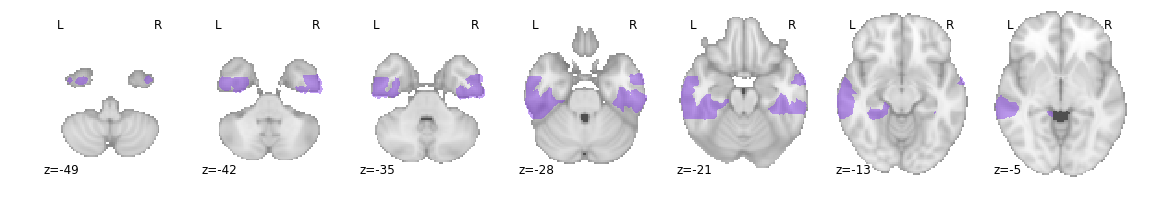


MANIPULATION


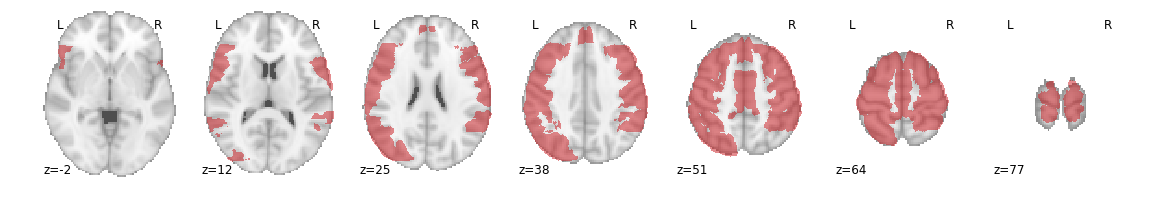


ANTICIPATION


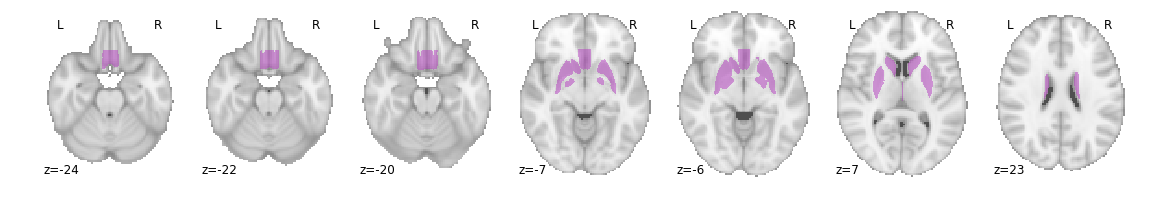


LANGUAGE


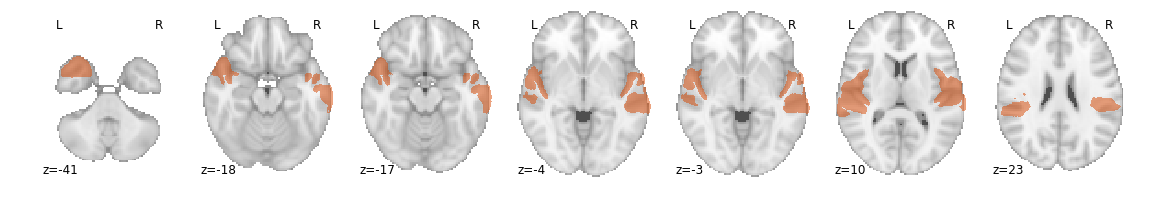


VISION


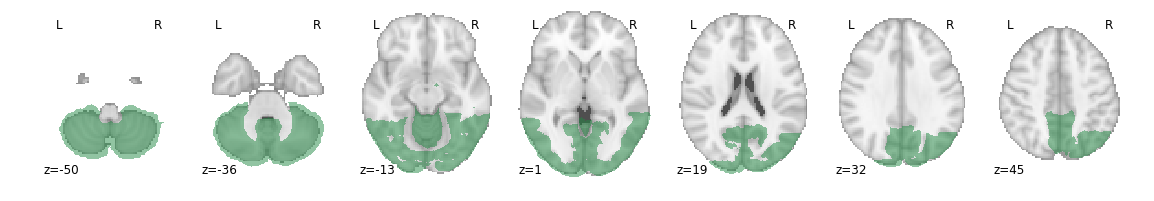


EMOTION


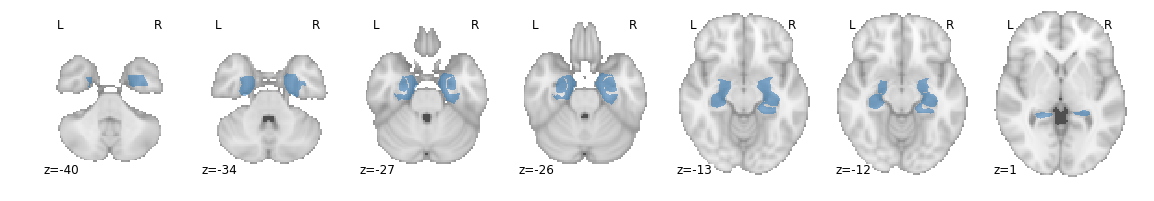


COGNITION


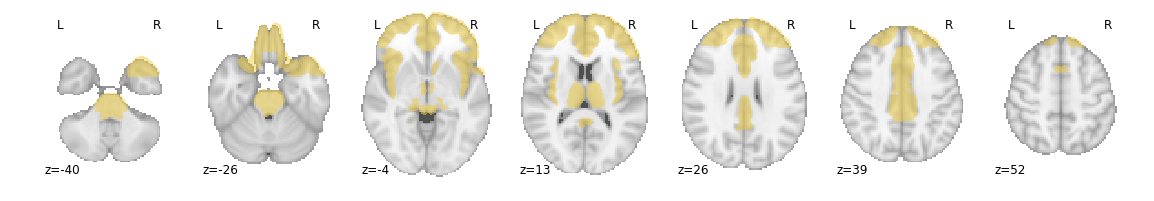

In [57]:
map_plane(dom_circuit_features, "figures/circuits/kmeans/circuits_k{:02d}".format(op_k[level]), 
          suffix="_z", cmaps=dom_cmaps, plane="z", cbar=False, vmin=0.0, vmax=2.0,
          verbose=False, print_fig=True, annotate=True)
for plane in ["x", "y"]:
    map_plane(dom_circuit_features, "figures/circuits/kmeans/circuits_k{:02d}".format(op_k[level]), 
          suffix="_{}".format(plane), cmaps=dom_cmaps, plane=plane, cbar=False, vmin=0.0, vmax=2.0,
          verbose=False, print_fig=False, annotate=True)

# Export circuit file

In [63]:
ordered_doms = ["EMOTION", "ANTICIPATION", "COGNITION", "VISION",
                "MANIPULATION", "MEANING", "LANGUAGE"]
dom_circuit_features = dom_circuit_features[ordered_doms]
dom_circuit_features.to_csv("circuits/circuits_domain_kmeans.csv")